In [1]:
# Setting up

# Import required modules
import glob
import scipy.io as sio
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('ggplot')
import seaborn as sns
import sklearn

# Which dataset?
print('Dataset: UCLA')

# Store the path of the folder containing the data
# Alternatively, could use user input - 
# path = input('Enter the file path of the data: ')
path = '/Users/AV/Dropbox/UCLA/cfgData/'

# Need to alphabetise and store the filenames in the path
Orig_TS_path_names = sorted(glob.glob(path + '*.mat'))
TS_path_names = sorted(glob.glob(path + '*.mat'))

Dataset: UCLA


In [2]:
# Import and store the fd averages
# Define a function that modifies the entries within TS_path_names based on the threshold fd value

def removePathNames(filePath, threshold_fd, TS_path_names):
    
    fdAvgs = pd.read_csv(filePath,header=None);

    indices2Del = np.where(fdAvgs > threshold_fd)[0]
    indices2Keep = np.where(fdAvgs <= threshold_fd)[0]
    
    for i in sorted(indices2Del, reverse=True):
        del TS_path_names[i]
    return TS_path_names, indices2Keep

filePath = '/Users/AV/Dropbox/UCLA/movementData/fdAvgs_UCLA.txt'
TS_path_names, indices2Keep = removePathNames(filePath, 0.30, TS_path_names)
indices2Keep = indices2Keep.tolist()

In [3]:
# Reading in the feature matrix data from the .txt file

# Import and store the feature matrix in the variable tsData
filePath = '/Users/AV/Desktop/FeatureMatrixData/element1_UCLA.txt'
tsData = pd.read_csv(filePath,header=None);

In [4]:
# # Creating the target column (COBRE)

# filePath = '/Users/AV/Dropbox/COBRE/participants.csv'
# COBRE = pd.read_csv(filePath,header=None);

# targetCol = COBRE.iloc[1:,2]
# targetCol = targetCol.tolist()
# targetCol = pd.DataFrame(data=targetCol, columns=['target'])
# targetCol = targetCol.iloc[indices2Keep,:]
# targetCol = np.asarray(targetCol,dtype=np.int)

# targetColModified = np.where(targetCol==1, 0, targetCol)
# targetCol = np.where(targetCol==2, 1, targetColModified)

In [73]:
# Creating the target column (UCLA)

# This function, when called, prompts the user to input a string
# which can be used to uniquely identify any SCZ data file
# It returns a binary target column (0 = control, 1 = SCZ)

def getTargetCol(TS_path_names):
    
    # string = input('Enter a string found in all filenames that only contain SCZ data: ')
    string = '-5'
    # In this case '-5' should do
    
    # Initialise and format a target column of length TS_path_names
    x = np.zeros(len(TS_path_names))
    x = x.astype(int)
    Diagnosis = np.reshape(x,(len(TS_path_names),1))

    # Initialise an index
    i = 0

    for path in TS_path_names:
        if string in path:
            # If the string is found, the data must be from a SCZ patient
            Diagnosis[i] = 1
            # Increment index
            i += 1
        else:
            # Increment index
            i += 1
    return Diagnosis

targetCol = getTargetCol(TS_path_names)

# # Shuffled target column
# np.random.shuffle(targetCol)

In [74]:
Control = (targetCol == 0).sum()
print('Control = ' + str(Control))
SCZ = (targetCol == 1).sum()
print('SCZ = ' + str(SCZ))
Total = SCZ + Control

Control = 123
SCZ = 49


In [75]:
# ROI selection

# This function takes a ROI as an input and gets the relevant slice (or rows) from tsData

def getROISlice(Orig_TS_path_names, tsData, ROI):
    
#     ROI = input('Which ROI is being analysed?: ')
    
    # Initialise a boolean
    validROI = False
    
    while validROI == False:
    
        # Rows per region of interest = len(TS_path_names)
        rowsPerROI = len(Orig_TS_path_names)
        [rows,cols] = tsData.shape

        # Get the rows corresponding to the mth region of interest, specified by the variable, indices2Keep
        ROISlice = tsData.iloc[((int(ROI)-1)*rowsPerROI):(int(ROI)*rowsPerROI),:]
        ROISlice = ROISlice.iloc[indices2Keep,:]

        # Assigning min and max values for input 'm'
        minROI = 1
        maxROI = int(rows/rowsPerROI)

        if minROI <= int(ROI) <= maxROI:
            validROI == True
            return ROISlice, ROI, maxROI
#         else:
#             print('Error: Please select a ROI between ' + str(minROI) + ' and ' + str(maxROI))
#             print('')
#             ROI = input('Which ROI is being analysed?: ')
            
# Need to z-score the selection of tsData
from scipy.stats import zscore
ROISlice, ROI, maxROI = getROISlice(Orig_TS_path_names, tsData,2)

# Assign the data to variables
y = np.ravel(targetCol)

In [76]:
# Need to store the data as a 3D feature matrix which will allow access to relevant slices
# [rows,cols,layers] = i, j, k = 185, 22, ROIs - varies element to element

featMat3D = np.zeros((len(TS_path_names),22,maxROI))

# Loop through each slice and store it in the matrix
for i in range(1, maxROI+1):
    featMat3D[:,:,i-1] = getROISlice(Orig_TS_path_names, tsData,i)[0]

def getFeatSlice(featMat3D, feature):
    if 0 < feature <= 22:
        FeatSlice = featMat3D[:,feature-1,:]
        return FeatSlice

FeatSlice = pd.DataFrame(getFeatSlice(featMat3D,3))

DataSlice = FeatSlice # FeatSlice or ROISlice
DataSlice_zscored = DataSlice.apply(zscore)
X = DataSlice_zscored

In [78]:
# Perform 10-Fold Cross Validation

# This function...

def get10FoldCVScore(X,y):
    
    # Import the support vector classifier and balance the classes
    from sklearn.svm import SVC
    svclassifier = SVC(kernel='linear') # , class_weight = {0:(SCZ/Total),1:(Control/Total)})

    # Split the data into training and test sets
    from sklearn.model_selection import StratifiedKFold
    n = 10
    skf = StratifiedKFold(n_splits=n)
    
    # Import accuracy score
    from sklearn.metrics import balanced_accuracy_score
    
    # Initialise a few variables
    scores = np.zeros(n)
    i = 0
    
    for train_index, test_index in skf.split(X,y):
        
        train_index = train_index.tolist()
        test_index = test_index.tolist()
        
#         print("Train:", train_index)
#         print('')
#         print("Validation:",test_index)
        
        X_train, X_test = X.iloc[train_index,:], X.iloc[test_index,:] 
        y_train, y_test = y[train_index], y[test_index]
        
        svclassifier.fit(X_train, y_train)
        y_pred = svclassifier.predict(X_test)
        
#         print('')
#         print('y_test = ', y_test)
#         print('')
#         print('y_pred = ', y_pred)
#         print('')
        
        scores[i] = '{0:.1f}'.format(balanced_accuracy_score(y_test, y_pred)*100)
#         print('Acc % = ', scores[i])
#         print('')
        
        # Increment index
        i += 1  
    return scores

# Store the function's output as a variable
scores = get10FoldCVScore(X,y)

# Print scores
print('10-fold CV scores as a percentage: ' + str(scores))
print('')

# Mean 10-fold CV score with an error of 1 std dev
print("Accuracy as a percentage: %0.1f (+/- %0.1f)" % (scores.mean(), scores.std()))

10-fold CV scores as a percentage: [58.5 60.  58.5 73.3 47.5 55.8 59.2 55.8 57.5 62.5]

Accuracy as a percentage: 58.9 (+/- 6.1)


In [10]:
# Plot SVM feature weights

# colors = ['r']*22

# from sklearn.svm import SVC
# svclassifier = SVC(kernel='linear')

# imp = svclassifier.fit(X,y).coef_.ravel()
# blue = np.where(imp > 0)

# i = 0

# for c in imp:
#     if c > 0:
#         colors[blue[0][i]] = 'b'
#         i += 1

# colors = np.array(colors).reshape(22,1)
# df3 = pd.DataFrame(data=colors)

# names = ['CO_Embed2_Dist_tau_d_expfit_meandiff', 'CO_FirstMin_ac', 'CO_HistogramAMI_even_2_5', 'CO_f1ecac', 'CO_trev_1_num',
#              'DN_HistogramMode_10', 'DN_HistogramMode_5', 'DN_OutlierInclude_n_001_mdrmd', 'DN_OutlierInclude_p_001_mdrmd',
#              'FC_LocalSimple_mean1_tauresrat', 'FC_LocalSimple_mean3_stderr', 'IN_AutoMutualInfoStats_40_gaussian_fmmi',
#              'MD_hrv_classic_pnn40', 'PeriodicityWang_th0_01', 'SB_BinaryStats_diff_longstretch0',
#              'SB_BinaryStats_mean_longstretch1', 'SB_MotifThree_quantile_hh', 'SB_TransitionMatrix_3ac_sumdiagcov',
#              'SC_FluctAnal_2_dfa_50_1_2_logi_prop_r1', 'SC_FluctAnal_2_rsrangefit_50_1_logi_prop_r1',
#              'SP_Summaries_welch_rect_area_5_1', 'SP_Summaries_welch_rect_centroid']
# names = np.array(names).reshape(22,1)

# df1 = pd.DataFrame(data=names)
# df2 = pd.DataFrame(data=imp)
# df = pd.concat([df1, df2, df3], axis = 1)
# df.columns = ["feat_names", "feat_imp", "colors"]
# df_sorted = df.sort_values(by=['feat_imp'])

# print(df_sorted)

# colors = df_sorted.iloc[:,2].tolist()

# ax = df_sorted.plot.bar(x='feat_names', y='feat_imp', color=colors, legend=False)
# ax.set_xlabel("Feature Names")
# ax.set_ylabel("Feature Weights")
# plt.show()

# 1.	CO_Embed2_Dist_tau_d_expfit_meandiff
# 2.	CO_FirstMin_ac
# 3.	CO_HistogramAMI_even_2_5
# 4.	CO_f1ecac
# 5.	CO_trev_1_num
# 6.	DN_HistogramMode_10
# 7.	DN_HistogramMode_5
# 8.	DN_OutlierInclude_n_001_mdrmd
# 9.	DN_OutlierInclude_p_001_mdrmd
# 10.	FC_LocalSimple_mean1_tauresrat
# 11.	FC_LocalSimple_mean3_stderr
# 12.	IN_AutoMutualInfoStats_40_gaussian_fmmi
# 13.	MD_hrv_classic_pnn40
# 14.	PeriodicityWang_th0_01
# 15.	SB_BinaryStats_diff_longstretch0
# 16.	SB_BinaryStats_mean_longstretch1
# 17.	SB_MotifThree_quantile_hh
# 18.	SB_TransitionMatrix_3ac_sumdiagcov
# 19.	SC_FluctAnal_2_dfa_50_1_2_logi_prop_r1
# 20.	SC_FluctAnal_2_rsrangefit_50_1_logi_prop_r1
# 21.	SP_Summaries_welch_rect_area_5_1
# 22.	SP_Summaries_welch_rect_centroid

In [11]:
# Compute the t-values (from a two-tail t-test) and the p-values
# Store these two values (t-value, then p-value) in each row, 22 in total for each feature

# This function...

def getTPVals(targetCol, DataSlice):
    
    from scipy.stats import stats,ttest_ind

    # Initialise the array and assign its shape
    tpValArray = np.zeros([22, 2])
    [rows, cols] = tpValArray.shape

    # Make a custom range of rows which can be used to distinguish the control data from the SCZ data
    # Find all instances of 0 in the target column (which would indicate control data)
    # and store the indices in an array
    a = np.where(targetCol == 0)[0]
    aStart = a[0]
    aEnd = a[-1] + 1

    # Find all instances of 1 in the target column (which would indicate SCZ data)
    # and store the indices in an array
    b = np.where(targetCol == 1)[0]
    bStart = b[0]
    bEnd = b[-1] + 1

    DataSlice = pd.DataFrame(data=DataSlice)

    # Loop through the array and store the t and p values
    for i in range(rows):

        # Calculate the t and p values by inputting the two halves of each of the 22 columns
        # of the normalised data into the ttest functions
        # Store the statistics in the variable, tpVal (which changes on each iteration of the outer loop)
        controlFeatCol = DataSlice.iloc[aStart:aEnd,i]
        SCZFeatCol = DataSlice.iloc[bStart:bEnd,i]
        tpVal = stats.ttest_ind(controlFeatCol, SCZFeatCol)

        for j in range(cols):

            # Store the values into each column
            tpValArray[i,j] = tpVal[j]

    # Since it is a two-tailed t-test, need to multiply the p-values by two (second column)
    tpValArray[:,1] = tpValArray[:,1] * 2

    # Formatting the tpValArray
    tpValDf = pd.DataFrame(data=tpValArray, columns=['t-value', 'p-value'])
    tpValDf.index.name = 'Feature i'

    # Sort the data (including the indices) in descending order by MAGNITUDE
    tpValDf_sorted = tpValDf.abs().sort_values(by='t-value',ascending=False)

    # Store the first five indices of the sorted dataframe - will need to use these
    # indices to access the relevant feature columns in X, the feature matrix
    indexVals = tpValDf_sorted.index.values
    signifTVals = indexVals[:5]

    return tpValDf, tpValDf_sorted, signifTVals

# Store the function's outputs
tpValDf, tpValDf_sorted, signifTVals = getTPVals(targetCol, DataSlice)

# print(tpValDf)
# print('')
# print(tpValDf_sorted)
# print('')
# print(signifTVals)
# print('')

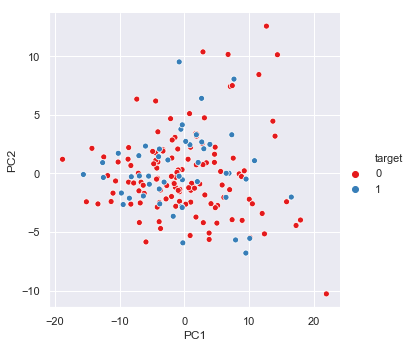

In [12]:
# PCA

# This function...

def showMePCAFig(DataSlice, targetCol):
    
    from sklearn.preprocessing import StandardScaler

    # Standardizing the features
    x = StandardScaler().fit_transform(DataSlice)

    from sklearn.decomposition import PCA
    pca = PCA(n_components=2)
    principalComponents = pca.fit_transform(x)
    principalDf = pd.DataFrame(data=principalComponents
                 , columns=['PC1', 'PC2'])

    targetCol_df = pd.DataFrame(data=targetCol, columns=['target'])

    finalDf = pd.concat([principalDf, targetCol_df], axis = 1)

    # print(finalDf)

    # Plotting the PCA scatterplot using Seaborn
    sns.set()
    ax = sns.relplot(x='PC1', y='PC2', data=finalDf, hue='target',palette='Set1')
    plt.show()
    return

showMePCAFig(DataSlice, targetCol)

Is DataSlice = FeatSlice or ROISlice? Enter 0 or 1 respectively: 0
Which Feature / ROI is being analysed?: 3


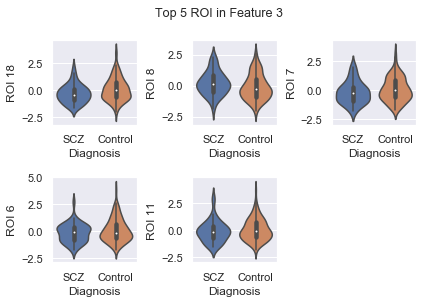

In [13]:
# Violin plots

# This function...

# boolean == 0: when looking at FeatSlices
# boolean == 1: when looking at ROISlices

def showMeViolinPlts(targetCol, signifTVals, DataSlice):
    
    boolean = int(input('Is DataSlice = FeatSlice or ROISlice? Enter 0 or 1 respectively: '))
    number = input('Which Feature / ROI is being analysed?: ')
    
    # Create an index for the subplot
    n = 1;
    
    fig = plt.figure()

    # Copy pasted (code enables custom selection of rows)
    a = np.where(targetCol == 0)[0]
    aStart = a[0]
    aEnd = a[-1] + 1

    b = np.where(targetCol == 1)[0]
    bStart = b[0]
    bEnd = b[-1] + 1
    
    DataSlice = pd.DataFrame(data=DataSlice)
    
    # Z-score the data
    DataSlice = DataSlice.apply(zscore)
    
    for i in signifTVals:
        # Obtain control feature i and SCZ feature i (all the rows)
        # from the ith column of the z-scored feature matrix
        cf_i = DataSlice.iloc[aStart:aEnd,i]
        sf_i = DataSlice.iloc[bStart:bEnd,i]

        # Convert into a dataframe
        df_feat_i = pd.DataFrame({'SCZ':sf_i,'Control':cf_i})

        # Violin plots
        ax = fig.add_subplot(2,3,n)
        ax = sns.violinplot(data=df_feat_i, order=['SCZ','Control'])
        plt.xlabel('Diagnosis')
        
        if boolean == 0:
            ylabel = 'ROI ' + str(i)
        elif boolean == 1:
            ylabel = 'Feature ' + str(i)
        plt.ylabel(ylabel)
        
        # Increment index
        n += 1;
        
    if boolean == 0:
         plt.suptitle('Top 5 ROI in Feature ' + str(number), fontsize=12.5, y=1.05)   
    elif boolean == 1:
        plt.suptitle('Top 5 Features in ROI ' + str(number), fontsize=12.5, y=1.05)
    plt.tight_layout()
    plt.show()
    return

showMeViolinPlts(targetCol, signifTVals, DataSlice)

Region  % Accuracy  ROI Error
    91       61.76  11.871832
   173       59.97  10.546094
    95       59.25  10.785662
   135       58.82   7.480080
   324       58.49  11.738948

Mean Accuracy (across all regions) = 50.00%

Mean Error (across all regions) = 4.21%



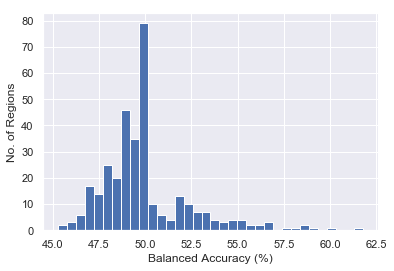

In [14]:
# Plotting the number of regions with balanced accuracies greater than 60%

def showMeROIAccPlot(maxROI, Orig_TS_path_names, tsData, targetCol, boolean):
    ''' This function displays the region accuracy plot and the top 5 regions
    having the highest accuracies
    If 0 is given as an input, this function suppresses any printed messages
    and plots but returns the mean regional accuracy '''

    # Initialise a few variables
    regions = np.zeros([maxROI])
    region_acc = np.zeros([maxROI])
    roiErr = np.zeros([maxROI])

    for n in range(1, maxROI+1):

        tsDataSlice = getROISlice(Orig_TS_path_names, tsData, n)[0]
        tsDataSlice_zscored = tsDataSlice.apply(zscore)

        # Assign the data to variables
        X = tsDataSlice_zscored
        y = np.ravel(targetCol)

        avgScore = get10FoldCVScore(X,y).mean()
        avgSTD = get10FoldCVScore(X,y).std()
        regions[n-1] = n
        region_acc[n-1] = avgScore
        roiErr[n-1] = avgSTD

    df = pd.DataFrame({'Region':regions,'% Accuracy':region_acc,'ROI Error':roiErr})
    df['Region'] = df.Region.astype(int)

    df_sorted = df.sort_values(by='% Accuracy',ascending=False)

    if boolean == 1:
        print(df_sorted[:5].to_string(index=False))
        print('')

        print('Mean Accuracy (across all regions) = ' +
        "{0:.2f}".format(df['% Accuracy'].mean()) + '%')
        print('')

        print('Mean Error (across all regions) = ' +
        "{0:.2f}".format(df['ROI Error'].mean()) + '%')
        print('')

        plt.hist(region_acc, bins='auto')
        plt.xlabel('Balanced Accuracy (%)')
        plt.ylabel('No. of Regions')
        plt.show()
        return
    elif boolean == 0:
        meanROIAcc = '{0:.2f}'.format(df['% Accuracy'].mean())
        AvgROIError = '{0:.2f}'.format(df['ROI Error'].mean())
        return meanROIAcc, AvgROIError

# Call the function to test
showMeROIAccPlot(maxROI, Orig_TS_path_names, tsData, targetCol, 1)

Feature  % Accuracy  Feat Error
      4       62.26   11.067990
      3       58.86    6.107897
      2       56.86   11.631010
     16       56.38    9.295139
     14       55.78   10.313079

Mean Accuracy (across all features) = 52.60%

Mean Error (across all features) = 9.74%



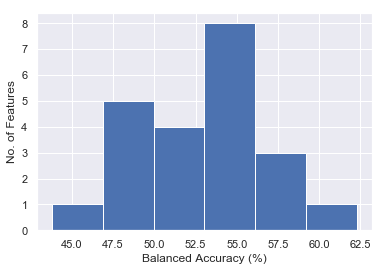

In [15]:
# Plot feature accuracies

def showMeFeatAccPlot(featMat3D, targetCol, boolean):
    ''' This function displays the feature accuracy plot and the top 5 features
    having the highest accuracies
    If 0 is given as an input, this function suppresses any printed messages
    and plots but returns the mean feature accuracy '''

    # Initialise a few variables
    feats = np.zeros(22)
    feat_acc = np.zeros(22)
    featErr = np.zeros([22])

    for n in range(1, 23):

        tsDataSlice = pd.DataFrame(getFeatSlice(featMat3D, n))
        tsDataSlice_zscored = tsDataSlice.apply(zscore)

        # Assign the data to variables
        X = tsDataSlice_zscored
        y = np.ravel(targetCol)

        avgScore = get10FoldCVScore(X,y).mean()
        avgSTD = get10FoldCVScore(X,y).std()
        feats[n-1] = n
        feat_acc[n-1] = avgScore
        featErr[n-1] = avgSTD

    df = pd.DataFrame({'Feature':feats,'% Accuracy':feat_acc,'Feat Error':featErr})
    df['Feature'] = df.Feature.astype(int)

    df_sorted = df.sort_values(by='% Accuracy',ascending=False)

    if boolean == 1:
        print(df_sorted[:5].to_string(index=False))
        print('')

        print('Mean Accuracy (across all features) = ' +
        "{0:.2f}".format(df['% Accuracy'].mean()) + '%')
        print('')

        print('Mean Error (across all features) = ' +
        "{0:.2f}".format(df['Feat Error'].mean()) + '%')
        print('')

        plt.hist(feat_acc, bins='auto')
        plt.xlabel('Balanced Accuracy (%)')
        plt.ylabel('No. of Features')
        plt.show()
        return
    elif boolean == 0:
        meanFeatAcc = '{0:.2f}'.format(df['% Accuracy'].mean())
        AvgFeatError = '{0:.2f}'.format(df['Feat Error'].mean())
        return meanFeatAcc, AvgFeatError, df_sorted

# Call the function to test
AvgFeatAcc, AvgFeatError, df_sorted = showMeFeatAccPlot(featMat3D, targetCol, 0)
showMeFeatAccPlot(featMat3D, targetCol, 1)

# Save sorted feats at fd = 0.30
# df_sorted.to_csv('sortedFeats_UCLA.txt', index=False)

      fd   SCZ  Control  Total  SCZ:Control  AvgROIAcc  AvgROIError  \
0   0.72  58.0    127.0  185.0         0.46      50.00         4.95   
1   0.69  57.0    127.0  184.0         0.45      50.06         4.88   
2   0.66  57.0    127.0  184.0         0.45      50.06         4.88   
3   0.63  57.0    127.0  184.0         0.45      50.06         4.88   
4   0.60  57.0    127.0  184.0         0.45      50.06         4.88   
5   0.57  57.0    127.0  184.0         0.45      50.06         4.88   
6   0.54  57.0    126.0  183.0         0.45      50.01         5.12   
7   0.51  56.0    126.0  182.0         0.44      50.07         4.85   
8   0.48  55.0    126.0  181.0         0.44      50.01         4.56   
9   0.45  55.0    125.0  180.0         0.44      49.84         4.72   
10  0.42  54.0    125.0  179.0         0.43      49.94         4.53   
11  0.39  54.0    124.0  178.0         0.44      49.95         4.84   
12  0.36  52.0    123.0  175.0         0.42      49.90         4.47   
13  0.

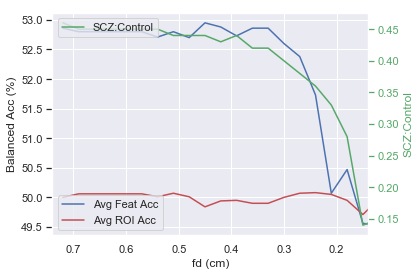

In [16]:
# Plot the fd vs balanced accuracy

# Import and store the fdArray
filePath = '/Users/AV/Desktop/FeatureMatrixData/fdArray_UCLA.txt'
fdArray = pd.read_csv(filePath);

print(fdArray)

fig, ax1 = plt.subplots()

AvgROIError = fdArray.iloc[:,6]
AvgFeatError = fdArray.iloc[:,8]

fd = fdArray.iloc[:,0]
SCZ2Control = fdArray.iloc[:,4]
AvgROIAcc = fdArray.iloc[:,5]
AvgFeatAcc = fdArray.iloc[:,7]

ax1.plot(fd, AvgFeatAcc,'b-')
# ax1.errorbar(fd, AvgFeatAcc, yerr=AvgFeatError, fmt='-o', capsize=5)

ax1.plot(fd, AvgROIAcc, 'r-')
# ax1.errorbar(fd, AvgROIAcc, yerr=AvgROIError, fmt='-o', capsize=5)

plt.xlim(max(fd)+0.02, min(fd)+0.02)
ax1.set_xlabel('fd (cm)')
ax1.set_ylabel('Balanced Acc (%)')

ax2 = ax1.twinx()
ax2.plot(fd, SCZ2Control,'g-')
ax2.set_ylabel('SCZ:Control', color='g')
ax2.tick_params('y', colors='g')
plt.grid(b=None)

ax1.legend(['Avg Feat Acc','Avg ROI Acc'],loc=3)
ax2.legend(['SCZ:Control'],loc=2)
fig.tight_layout()
plt.show()

In [17]:
# # fd variation across subjects

# filePath = '/Users/AV/Dropbox/UCLA/movementData/fdAvgs_UCLA.txt'
# fdAvgs = pd.read_csv(filePath,header=None, names=['FD Avgs']);

# fdAvgs.hist(column='FD Avgs')

# plt.xlim(max(fd), min(fd))
# plt.title('FD Distribution')
# plt.xlabel('FD Averages (cm)')
# plt.ylabel('No. of Subjects')
# plt.show()

In [18]:
# # No. of subjects left as fd decreases

# SCZ = fdArray.iloc[:,1]
# Control = fdArray.iloc[:,2]

# fdArray.plot.line(x='fd', y=['SCZ', 'Control'])

# plt.xlim(max(fd), min(fd))
# plt.title('FD vs Subjects Remaining')
# plt.xlabel('FD Averages (cm)')
# plt.ylabel('No. of Subjects')
# plt.show()

In [19]:
'''UCLA feat and ROI v fd plots'''

'UCLA feat and ROI v fd plots'

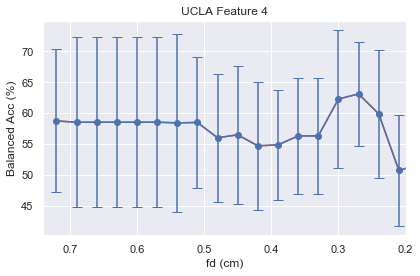

In [20]:
# Plot feat_BalancedAcc as it varies with fd

# Import and store the fdArray
filePath = '/Users/AV/Desktop/FeatureMatrixData/feat_BalancedAcc_UCLA.txt'
df = pd.read_csv(filePath);

# print(df)

fig, ax1 = plt.subplots()

fd = df.iloc[:,0]
feat_Balanced = df.iloc[:,1]
stdDev = df.iloc[:,2]

ax1.plot(fd, feat_Balanced, 'r-')
ax1.errorbar(fd, feat_Balanced, yerr=stdDev, fmt='-o', capsize=5)

plt.title('UCLA Feature 4')
plt.xlim(max(fd)+0.02, min(fd)+0.02)
ax1.set_xlabel('fd (cm)')
ax1.set_ylabel('Balanced Acc (%)')

fig.tight_layout()
plt.show()

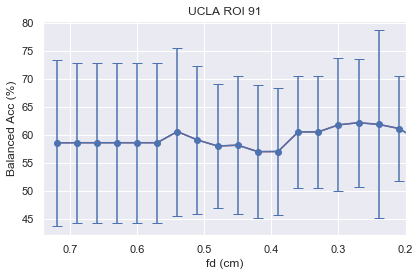

In [21]:
# Plot ROI_BalancedAcc as it varies with fd

# Import and store the fdArray
filePath = '/Users/AV/Desktop/FeatureMatrixData/ROI_BalancedAcc_UCLA.txt'
df = pd.read_csv(filePath);

# print(df)

fig, ax1 = plt.subplots()

fd = df.iloc[:,0]
ROI_Balanced = df.iloc[:,1]
stdDev = df.iloc[:,2]

ax1.plot(fd, ROI_Balanced, 'r-')
ax1.errorbar(fd, ROI_Balanced, yerr=stdDev, fmt='-o', capsize=5)

plt.title('UCLA ROI 91')
plt.xlim(max(fd)+0.02, min(fd)+0.02)
ax1.set_xlabel('fd (cm)')
ax1.set_ylabel('Balanced Acc (%)')

fig.tight_layout()
plt.show()

In [22]:
'''COBRE feat and ROI v fd plots'''

'COBRE feat and ROI v fd plots'

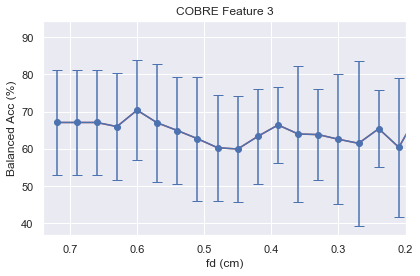

In [23]:
# Plot feat_BalancedAcc as it varies with fd

# Import and store the fdArray
filePath = '/Users/AV/Desktop/FeatureMatrixData/feat_BalancedAcc_COBRE.txt'
df = pd.read_csv(filePath);

# print(df)

fig, ax1 = plt.subplots()

fd = df.iloc[:,0]
feat_Balanced = df.iloc[:,1]
stdDev = df.iloc[:,2]

ax1.plot(fd, feat_Balanced, 'r-')
ax1.errorbar(fd, feat_Balanced, yerr=stdDev, fmt='-o', capsize=5)

plt.title('COBRE Feature 3')
plt.xlim(max(fd)+0.02, min(fd)+0.02)
ax1.set_xlabel('fd (cm)')
ax1.set_ylabel('Balanced Acc (%)')

fig.tight_layout()
plt.show()

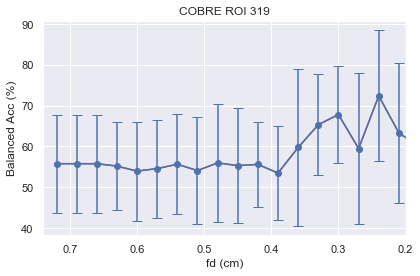

In [24]:
# Plot ROI_BalancedAcc as it varies with fd

# Import and store the fdArray
filePath = '/Users/AV/Desktop/FeatureMatrixData/ROI_BalancedAcc_COBRE.txt'
df = pd.read_csv(filePath);

# print(df)

fig, ax1 = plt.subplots()

fd = df.iloc[:,0]
ROI_Balanced = df.iloc[:,1]
stdDev = df.iloc[:,2]

ax1.plot(fd, ROI_Balanced, 'r-')
ax1.errorbar(fd, ROI_Balanced, yerr=stdDev, fmt='-o', capsize=5)

plt.title('COBRE ROI 319')
plt.xlim(max(fd)+0.02, min(fd)+0.02)
ax1.set_xlabel('fd (cm)')
ax1.set_ylabel('Balanced Acc (%)')

fig.tight_layout()
plt.show()

    UCLA Feature  UCLA Feat Acc (%)  UCLA Feat Error (%)
15             1              50.34            12.141763
2              2              56.86            11.631010
1              3              58.86             6.107897
0              4              62.26            11.067990
7              5              54.44            10.250678
19             6              47.39            10.560630
21             7              43.81             7.177945
13             8              51.54            12.107535
8              9              54.10             9.905554
20            10              47.38             6.447294
11            11              53.37             9.876037
14            12              50.51             5.058547
18            13              47.47            14.665746
4             14              55.78            10.313079
12            15              51.96             9.386501
3             16              56.38             9.295139
9             17              5

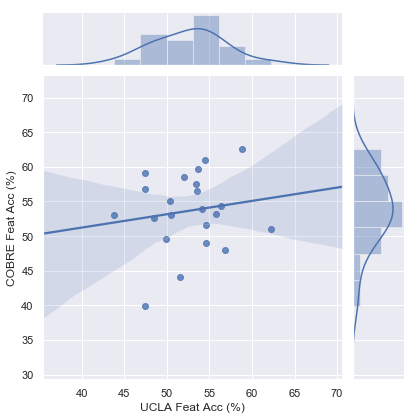

In [122]:
filePath = '/Users/AV/Desktop/FeatureMatrixData/sortedFeats_UCLA.txt'
df1 = pd.read_csv(filePath);
df1 = df1.sort_values(by='Feature')
df1.columns = ['UCLA Feature', 'UCLA Feat Acc (%)', 'UCLA Feat Error (%)']
uclaFeats = df1.iloc[:,1]
print(df1)

filePath = '/Users/AV/Desktop/FeatureMatrixData/sortedFeats_COBRE.txt'
df2 = pd.read_csv(filePath);
df2 = df2.sort_values(by='Feature')
df2.columns = ['COBRE Feature', 'COBRE Feat Acc (%)', 'COBRE Feat Error (%)']
cobreFeats = df2.iloc[:,1]
print(df2)

sns.jointplot(uclaFeats, cobreFeats, kind='reg')
plt.show()

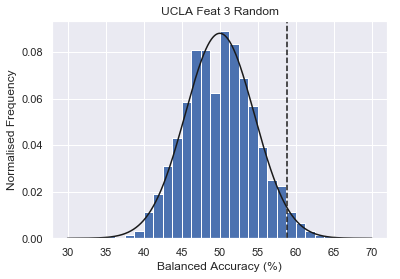

The p-value for Feature 3 in the UCLA dataset =  0.028


In [155]:
# Plot random histograms for both data sets
from scipy import stats

# UCLA

filePath = '/Users/AV/Desktop/FeatureMatrixData/feat3BalancedAcc_UCLA_shuff.txt'
df3 = pd.read_csv(filePath);

feat3_acc = df3.iloc[:,1]

plt.hist(feat3_acc, bins='auto', density=True)
plt.xlabel('Balanced Accuracy (%)')
plt.ylabel('Normalised Frequency')
plt.title('UCLA Feat 3 Random')

# find minimum and maximum of xticks, so we know
# where we should compute theoretical distribution
xt = plt.xticks()[0]  
xmin, xmax = min(xt), max(xt)  
lnspc = np.linspace(xmin, xmax, len(feat3_acc))

# Normal distribution
m, s = stats.norm.fit(feat3_acc) # get mean and standard deviation  
pdf_g = stats.norm.pdf(lnspc, m, s) # now get theoretical values in our interval  
plt.plot(lnspc, pdf_g, label="Norm", color='k') # plot it

# P-Value Calculations

actualFeat3Acc_UCLA = 58.86

plt.axvline(x=actualFeat3Acc_UCLA, color='k', linestyle='--')

plt.show()

arr = np.asarray(feat3_acc)

pval_UCLA = len(np.where(arr>=actualFeat3Acc_UCLA)[0])/len(arr)
print('The p-value for Feature 3 in the UCLA dataset = ', str(pval_UCLA))

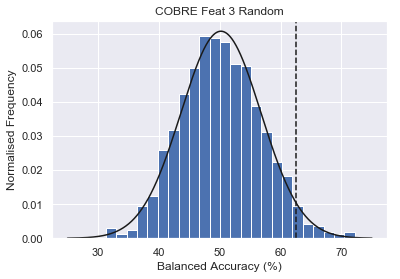

The p-value for Feature 3 in the COBRE dataset =  0.031
0.007


In [156]:
# COBRE

filePath = '/Users/AV/Desktop/FeatureMatrixData/feat3BalancedAcc_COBRE_shuff.txt'
df4 = pd.read_csv(filePath);

feat3_acc = df4.iloc[:,1]

plt.hist(feat3_acc, bins='auto', density=True)
plt.xlabel('Balanced Accuracy (%)')
plt.ylabel('Normalised Frequency')
plt.title('COBRE Feat 3 Random')

# find minimum and maximum of xticks, so we know
# where we should compute theoretical distribution
xt = plt.xticks()[0]  
xmin, xmax = min(xt), max(xt)  
lnspc = np.linspace(xmin, xmax, len(feat3_acc))

# Normal distribution
m, s = stats.norm.fit(feat3_acc) # get mean and standard deviation  
pdf_g = stats.norm.pdf(lnspc, m, s) # now get theoretical values in our interval  
plt.plot(lnspc, pdf_g, label="Norm", color='k') # plot it

# P-Value Calculations

actualFeat3Acc_COBRE = 62.58

plt.axvline(x=actualFeat3Acc_COBRE, color='k', linestyle='--')

plt.show()

arr = np.asarray(feat3_acc)

pval_COBRE = len(np.where(arr>=actualFeat3Acc_COBRE)[0])/len(arr)
print('The p-value for Feature 3 in the COBRE dataset = ', str(pval_COBRE))

pvalues = [pval_UCLA, pval_COBRE]
pvalues = np.asarray(pvalues)

pvalFeat3 = "%.3f" % stats.combine_pvalues(pvalues, method='fisher')[1]
print(pvalFeat3)

In [190]:
# Store and combine p-values for both datasets

# Initialise pval_UCLA and pval_COBRE 1x22 array of zeros
pvals_UCLA = np.zeros(22)
pvals_COBRE = np.zeros(22)
pvals_combined = np.zeros(22)

filePath1 = '/Users/AV/Desktop/FeatureMatrixData/featBalancedAcc_UCLA_shuff.txt'
shuffData_UCLA = pd.read_csv(filePath1);

filePath2 = '/Users/AV/Desktop/FeatureMatrixData/featBalancedAcc_COBRE_shuff.txt'
shuffData_COBRE = pd.read_csv(filePath2);

for feature in range(1, 23):
    
    # Get the rows corresponding to each feature
    shuffFeatSlice_UCLA = shuffData_UCLA.iloc[((int(feature)-1)*1000):(int(feature)*1000),:]
    shuffFeatSlice_COBRE = shuffData_COBRE.iloc[((int(feature)-1)*1000):(int(feature)*1000),:]
    
    feat_acc_UCLA = shuffFeatSlice_UCLA.iloc[:,1]
    feat_acc_COBRE = shuffFeatSlice_COBRE.iloc[:,1]
    
    arr_UCLA = np.asarray(feat_acc_UCLA)
    arr_COBRE = np.asarray(feat_acc_COBRE)
    
    uclaFeats = np.asarray(uclaFeats)
    cobreFeats = np.asarray(cobreFeats)
    
    pval1 = len(np.where(arr_UCLA>=uclaFeats[int(feature)-1])[0])/len(arr_UCLA)
#     print('The p-value for Feature', str(feature), ' in the UCLA dataset = ', str(pval1))
    pval2 = len(np.where(arr_COBRE>=cobreFeats[int(feature)-1])[0])/len(arr_COBRE)
#     print('The p-value for Feature', str(feature), ' in the COBRE dataset = ', str(pval2))
    
    pvals_UCLA[int(feature)-1] = pval1
    pvals_COBRE[int(feature)-1] = pval2

    pvalues = [pval1, pval2]
    pvalues = np.asarray(pvalues)

    pvals_combined[int(feature)-1] = "%.3f" % stats.combine_pvalues(pvalues, method='fisher')[1]
    
# print('Combined p-values =', pvals_combined)

df = pd.DataFrame(data=pvals_combined, columns=['Combined P-Values'])

print(df)

# df.to_csv('combined_pvals_22features.txt', index=False)

    Combined P-Values
0               0.338
1               0.153
2               0.006
3               0.018
4               0.049
5               0.944
6               0.611
7               0.676
8               0.198
9               0.316
10              0.135
11              0.411
12              0.217
13              0.129
14              0.125
15              0.090
16              0.093
17              0.315
18              0.539
19              0.237
20              0.171
21              0.614
